In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_posteriors(likelihoods, priors = None):
    """ Take likelihood and prior probabilities and compute posteriors
            using Bayes Theorem. """
    if priors is None: # Assume uniform distribution if priors not given
        return likelihoods / np.sum(likelihoods)
    else:
        marginals = likelihoods * priors
        return marginals / np.sum(marginals)

# All candy flavors
CANDY = 'cherry lime apple'.split().index

Let's first use example data from lecture slides to help verify algorithm correctness.

In [3]:
hypotheses = np.array([
    # cherry lime
    [ 1,     0],     # H1
    [ .75,   .25],   # H2
    [ .5,    .5],    # H3
    [ .25,   .75],   # H4
    [ 0,     1]      # H5
])
priors = np.array([.1, .2, .4, .2, .1])
data = np.array([CANDY('lime')]*10)

# All hypotheses
hypotheses_names = np.array(['H%d'%(i+1) for i in range(hypotheses.shape[0])])

** Comments for following code please see 1.a section **

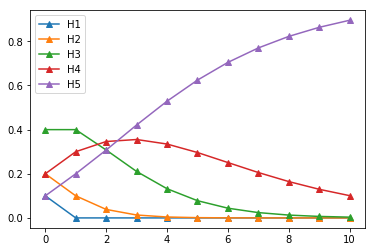

In [4]:
posteriors_data = np.expand_dims(priors, 1)
for i in range(10):
    posteriors_data = np.hstack([posteriors_data, 
        np.expand_dims(get_posteriors(hypotheses[:, data[i]], posteriors_data[:, -1]), 1)])

for i in range(hypotheses.shape[0]):
    plt.plot(posteriors_data[i, :], marker='^', label=hypotheses_names[i])
plt.legend()

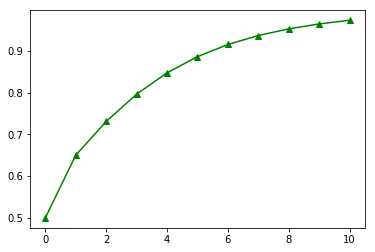

In [5]:
plt.plot(np.dot(posteriors_data.T, hypotheses[:, CANDY('lime')]), marker='^', color='g')

Now switching back to data given in the assignment.

In [6]:
hypotheses = np.array([
    # cherry lime  apple
    [ .8,   .15,   .05],  # H1
    [ .6,   .3,    .1],   # H2
    [ .4,   .5,    .1],   # H3
    [ .2,   .4,    .4],   # H4
    [ .1,   .2,    .7]    # H5
])
priors = np.array([.1, .3, .2, .15, .25])
data = np.array(list(map(CANDY,
    'cherry lime apple cherry apple apple lime apple lime apple'.split())))

# All hypotheses
hypotheses_names = np.array(['H%d'%(i+1) for i in range(hypotheses.shape[0])])

### 1.a. Bayesian Learning

Goal of this section is to compute the posterior probabilities given a sequence of observations.  
The algorithm is implemented based on following recursive equation:

When $n \ge 2$:
$$ P(H_i | D_1 ... D_n) = \frac{P(H_i, D_1 ... D_n)}{P(D_1 ... D_n)}=\frac{P(D_n|D_1 ... D_{n-1} H_i)\cdot P(H_i|D_1 ... D_{n-1}) \cdot P(D_1 ... D_n) }{P(D_1 ... D_n)} = P(D_n| H_i) \cdot P(H_i|D_1 ... D_{n-1}) $$

When $n = 1$:
$$ P(H_i | D_1) = \frac{P(D_1 | H_i) \cdot P(H_i)}{\sum_j P(D_1 | H_j) \cdot P(H_j)} $$

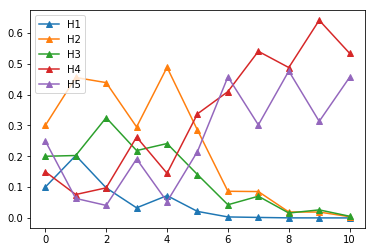

In [7]:
posteriors_data = np.expand_dims(priors, 1)
for i in range(10):
    # Take last posteriors as priors
    priors_new = posteriors_data[:, -1]
    # Compute new posteriors using bayes theorem
    posteriors_new = get_posteriors(hypotheses[:, data[i]], priors_new)
    # Append new posteriors
    posteriors_data = np.hstack([posteriors_data, np.expand_dims(posteriors_new, 1)])

for i in range(hypotheses.shape[0]):
    plt.plot(posteriors_data[i, :], marker='^', label='H%d'%(i+1))
plt.legend()

### 1.b. Bayesian Prediction

For any $n \ge 1$:

$$P(D_{n+1} | D_1 ... D_n) = \frac{\sum_i P(D_1 ... D_n, D_{n+1} H_i)}{P(D_1 ... D_n)} = \sum_i P(D_{n+1}|H_i) \cdot   P(H_i | D_1 ... D_n) $$

Therefore,

$$P(D_{n+1} = \text{"CHERRY"} | D_1 ... D_n) = \sum_i P(D = \text{"CHERRY"} |H_i) \cdot   P(H_i | D_1 ... D_n) $$

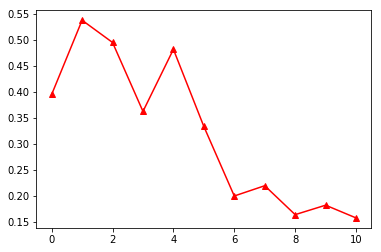

In [8]:
plt.plot(np.dot(posteriors_data.T, hypotheses[:, CANDY('cherry')]), marker='^', color='r')

### 1.c. MAP Learning

The posterior probabilities are the same as 1.a. but MAP would only accept the hypothesis that maximizes the posterior probability.

In [9]:
list(hypotheses_names[np.argmax(posteriors_data, axis = 0)])

['H2', 'H2', 'H2', 'H2', 'H2', 'H4', 'H5', 'H4', 'H4', 'H4', 'H4']

The "square" indicates the hypothesis selected by MAP learning:

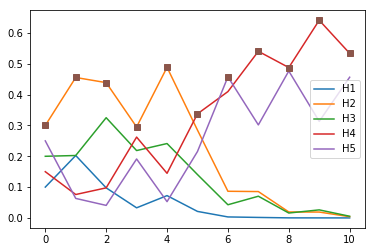

In [10]:
for i in range(hypotheses.shape[0]):
    plt.plot(posteriors_data[i, :], label=hypotheses_names[i])
plt.plot(np.max(posteriors_data, axis = 0), 's')
plt.legend()

### 1.d. MAP Prediction

$$H_{MAP} = H_m \text{ where } m = argmax_i P(H_i|D_1...D_n)$$

For any $n \ge 1$:

$$P(D_{n+1} | D_1 ... D_n, H_{MAP}) = P(D_{n+1} | H_{MAP}) $$

Therefore,

$$P(D_{n+1} = \text{ "CHERRY" } | D_1 ... D_n, H_{MAP}) = P(D = \text{ "CHERRY" } | H_{MAP})$$

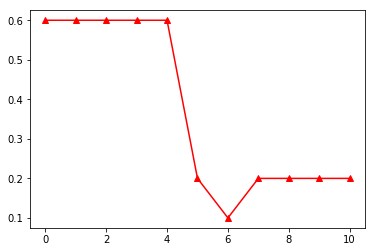

In [11]:
plt.plot(hypotheses[np.argmax(posteriors_data, axis = 0), CANDY('cherry')], marker='^', color='r')

### 2.a K-Means and EM

In [12]:
def kmeans(X, num_clusters = 2, prototypes = None):
    num_points, dimensions = X.shape
#     if prototypes is None: # Use random cluster centers or "prototypes" if they are not given
#         prototypes = np.random.rand(num_clusters, dimensions)
    for t in range(20): # Iteratively update memberships and prototypes
        distances = np.column_stack([
            np.linalg.norm(X - np.expand_dims(prototypes[j], 0), axis = 1) for j in range(num_clusters)])
        memberships = np.argmin(distances, axis = 1)
        prototypes = np.array([np.mean(X[memberships==j], axis = 0) for j in range(num_clusters)])
    return dict(memberships = memberships, prototypes = prototypes)

In [13]:
from scipy.stats import multivariate_normal

def em(X, num_clusters = 2, prototypes = None):
    num_points, dimensions = X.shape
#     if prototypes is None: # Use random cluster centers or "prototypes" if they are not given
#         prototypes = np.random.rand(num_clusters, dimensions) # shape: (num_clusters, dimensions)
    weights = np.ones(num_clusters)
    covariance_matrices = np.array([np.eye(dimensions) for j in range(num_clusters)])
    for t in range(20):
        # E step
        gaussians = map(lambda j: multivariate_normal(mean=prototypes[j], cov=covariance_matrices[j]), range(num_clusters))
        probs = np.expand_dims(weights, 1) * np.array([g.pdf(X) for g in gaussians]) # shape: (num_clusters, num_points)
        probs /= np.expand_dims(np.sum(probs, axis = 0), 0) # normalize over clusters

        # M step
        normalizer = 1 / np.sum(probs, axis = 1) # shape: (num_clusters,)
        prototypes = np.dot(probs, X) * np.expand_dims(normalizer, 1)
        for j in range(num_clusters):
            X_centered = X - np.expand_dims(prototypes[j], 0) # shape: (num_points, dimensions)
            covariance_matrices[j] = (np.dot(probs[j], np.matmul(
                    np.expand_dims(X_centered, 2),
                    np.expand_dims(X_centered, 1)).reshape((num_points, -1))
            ) * normalizer[j]).reshape((dimensions, dimensions))
        weights = np.squeeze(normalizer) / num_points
    return dict(memberships = np.argmax(probs, axis = 0), prototypes = prototypes, covariance_matrices = covariance_matrices)

** Notes on EM algorithm **

** Expectation: **

$$ \gamma_{nk} = \frac{ \pi_k \mathcal{N}(\vec{x_n} | \vec{\mu_k}, \Sigma_k)}{\sum_j \pi_j \mathcal{N}(\vec{x_n} | \vec{\mu_j}, \Sigma_j)} $$

** Maximization: **

$$ \hat {\mu_k} = \frac{1}{N_i} \sum_n \gamma_{nk} \vec{x_n} $$

$$ \hat{\Sigma_k} = \frac{1}{N_i} \sum_n \gamma_{nk} (\vec{x_n}-\hat {\mu_k})(\vec{x_n}-\hat {\mu_k})^T$$

$$ \hat{\pi_k} = \frac{N_k}{N} $$

where

$$ N_k = \sum_n \gamma_{nk }$$

Likelihood:

$$\ln P(X|\vec{\mu},\Sigma,\vec{\pi}) = \sum_n \ln \left[\sum_k \pi_k \mathcal{N}(\vec{x_n} | \vec{\mu_k}, \Sigma_k) \right]$$

Normal distribution:

$$\mathcal{N}(\vec{x} | \vec{\mu}, \Sigma) = \frac{exp\left( -\frac{1}{2}(\vec x -\vec \mu)^T\Sigma^{-1}(\vec x -\vec \mu) \right)}{\sqrt{(2\pi)^k |\Sigma|}}$$

### 2.b. Generate 100 data points

Here are 100 data points sampled from two Gaussians.

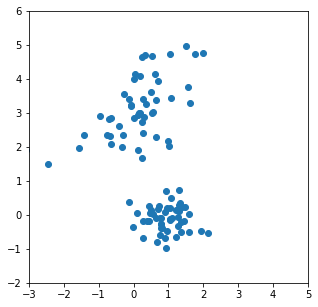

In [14]:
dataset = np.vstack([
    np.random.multivariate_normal([1, 0], np.eye(2) * 0.2, 50),
    np.random.multivariate_normal([0, 3], [[1, 0.6], [0.6, 1]], 50),
])

np.random.shuffle(dataset)

plt.figure(figsize = (5, 5))
plt.axis([-3, 5, -2, 6])
plt.scatter(dataset[:, 0], dataset[:, 1])

### 2.c. Clustering Plot

In [15]:
from matplotlib.patches import Ellipse

def plot_clusters(result):
    plt.figure(figsize = (5, 5))
    plt.axis([-3, 5, -2, 6])
    plt.scatter(dataset[:, 0], dataset[:, 1], c = result['memberships'])
    plt.scatter(result['prototypes'][:, 0], result['prototypes'][:, 1], marker = 'x', s=500, c='r')
    if 'covariance_matrices' in result:
        ax = plt.gcf().gca()
        for j, cov in enumerate(result['covariance_matrices']):
            eigenvalues, eigenvectors = np.linalg.eig(cov)
            principal_variances = np.sqrt(eigenvalues)
            sigma_scale = 2
            ellipse = Ellipse(xy = result['prototypes'][j],
                  width = principal_variances[0] * sigma_scale * 2, height = principal_variances[1] * sigma_scale * 2,
                  angle = np.rad2deg(np.arccos(eigenvectors[0, 0])), fill = False)
            ax.add_artist(ellipse)

Plot of K-means results after 20 iterations.

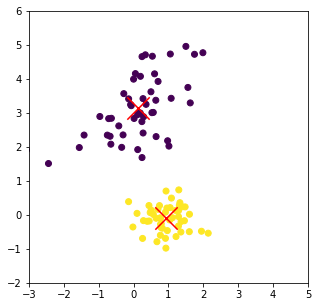

In [16]:
plot_clusters(kmeans(dataset, 2, prototypes = [[-1, 4], [3, 0]]))

Plot of EM results after 20 iterations.

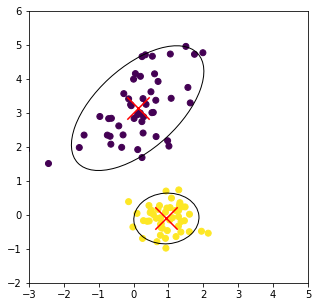

In [17]:
plot_clusters(em(dataset, 2, prototypes = [[-1, 4], [3, 0]]))

### 2.d. Clustering Plot 2

Plot of K-means results after 20 iterations.

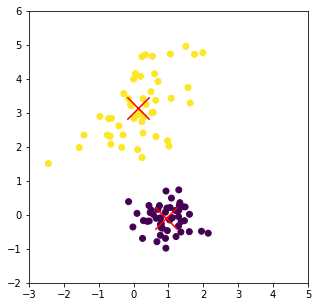

In [18]:
plot_clusters(kmeans(dataset, 2, prototypes = [[0, 0], [2, 2]]))

Plot of EM results after 20 iterations.

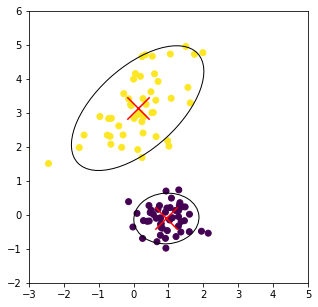

In [19]:
plot_clusters(em(dataset, 2, prototypes = [[0, 0], [2, 2]]))